In [1]:
from rsnautils import *

In [2]:
torch.cuda.set_device(3)
pre = 'xrn50_win'

In [3]:
fns = L(list(df_samp.fname)).map(filename)
fn = fns[0]
fn

'ID_2a8702d25'

In [4]:
splits = split_data(df_samp)
p1 = L.range(df_samp)[df_samp.PatientID==df_samp.PatientID[0]]
assert len(p1) == len(set(p1) & set(splits[0]))

In [5]:
bs,nw = 128,8

(tensor(0.1864), tensor(1.0619), torch.Size([128, 3, 96, 96]), 902)

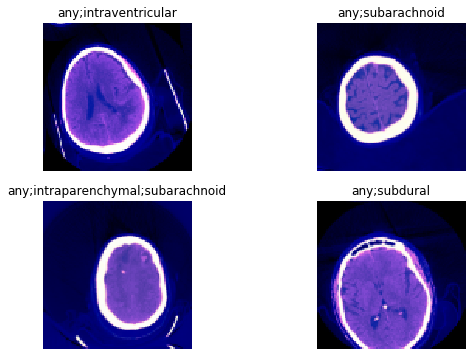

In [9]:
dbch = get_data_pil(fns, 128, splits=splits, sz=96, use_hist=True)
xb,yb = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4, figsize=(9,6))
xb.mean(),xb.std(),xb.shape,len(dbch.train)

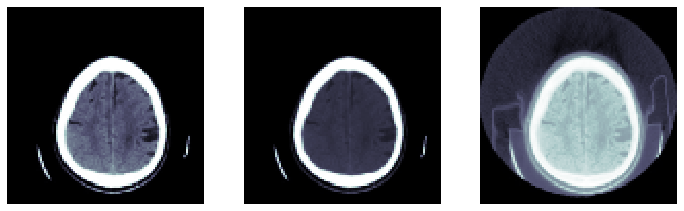

In [10]:
show_images(xb[0])

In [7]:
def get_learner(lf, fp16=True):
    learn = cnn_learner(dbch, xresnet50, loss_func=lf, opt_func=opt_func, metrics=metrics)
    if fp16: learn = learn.to_fp16()
    return learn

In [34]:
learn = get_learner(get_loss(0.14*2))

In [35]:
learn.model[1][8].bias.data = to_device(logit(avg_lbls))

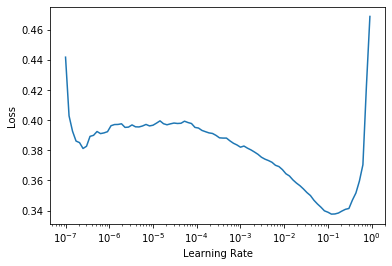

In [36]:
learn.lr_find()

In [37]:
def do_fit(epochs,lr, freeze=True, pct=None):
    if freeze:
        learn.freeze()
        cb = ShortEpochCallback(pct=pct, short_valid=False) if pct else None
        learn.fit_one_cycle(1, slice(lr), cbs=cb)
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))

In [38]:
learn.dls = get_data_pil(fns, 128, splits=splits, sz=96, use_hist=False)

In [39]:
do_fit(1, 2e-2, pct=0.1)

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.156868,0.160018,0.854513,0.827491,03:03


In [40]:
learn.save(f'{pre}tmp')

## Full DICOM files

(maybe not needed, unless we do learned windows)

In [41]:
splits = split_data(df_comb)
fns = L(list(df_comb.fname)).map(filename)

torch.Size([3, 512, 512])

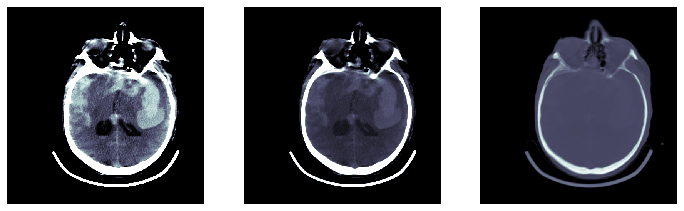

In [42]:
dcm = dcm_tfm(fns[2], **bone_args)
show_images(dcm)
dcm.shape

In [45]:
dls = get_data_dcm(fns, 128, splits=splits, win_args=bone_args, sz=96)
x,y = to_cpu(dls.one_batch())
x.shape

torch.Size([128, 3, 96, 96])

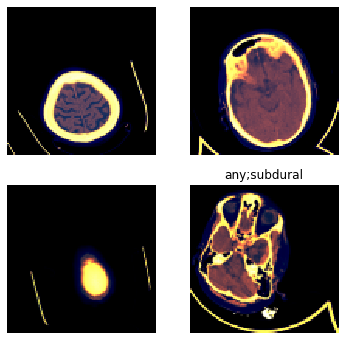

In [46]:
dls.show_batch(max_n=4)

In [47]:
learn.loss_func = get_loss(1.0)
learn.dls = dls

In [48]:
learn.load(f'{pre}tmp');

In [1]:
do_fit(1, lr=1e-2, pct=0.1)
learn.save(f'{pre}2a')

## Prepare for submission

In [ ]:
tst = test_dl(dbch, df_tst.fname.values)
x = tst.one_batch()[0]
x.min(),x.max()

In [ ]:
preds,targs = learn.get_preds(dl=tst)
preds_clipped = preds.clamp(.0001, .999)

In [ ]:
df_csv = submission(df_tst, preds_clipped)
df_csv.head()

In [ ]:
from IPython.display import FileLink, FileLinks
FileLink('submission.csv')